<a href="https://colab.research.google.com/github/ShahaRaz/ComputerVision2021B/blob/main/Lab1_Prep_7march.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from scipy.signal import convolve, convolve2d, correlate2d

## Get Media

In [2]:
# Uploaded to github servers 
!wget https://user-images.githubusercontent.com/55464049/110137357-6cb35780-7dd9-11eb-98a9-54a66d9cdd0c.jpg -O zebra.jpg
image = cv2.imread('zebra.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert image to rgb.

--2021-03-06 09:21:57--  https://user-images.githubusercontent.com/55464049/110137357-6cb35780-7dd9-11eb-98a9-54a66d9cdd0c.jpg
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239177 (234K) [image/jpeg]
Saving to: ‘zebra.jpg’

zebra.jpg           100%[===================>] 233.57K  --.-KB/s    in 0.02s   

2021-03-06 09:21:57 (14.5 MB/s) - ‘zebra.jpg’ saved [239177/239177]



## 1. Gaussian Blur

In [3]:
def add_guassian_noise(img: np.ndarray, mean: float, sigma: float) -> np.ndarray:
    row, col, _ = img.shape
    gaussian = np.random.normal(mean, sigma, (row, col)) # Creating matrix with noramlly distributed values. :-)
#     display(gaussian)

    noisy_image = np.zeros(img.shape, np.float32)

    if len(img.shape) == 2: # If this image is in grey scale
        noisy_image = img + gaussian
    else: # add the blur to each channel (RGB)
        noisy_image[:, :, 0] = img[:, :, 0] + gaussian
        noisy_image[:, :, 1] = img[:, :, 1] + gaussian
        noisy_image[:, :, 2] = img[:, :, 2] + gaussian
    # Normalize the result matrix to values between 0 to 255 based on the max value.
#     cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
    return noisy_image.astype(np.uint8) # Change the dtype to uint (1byte, vals in range [0,255])

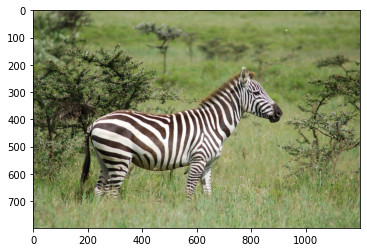

In [4]:
plt.imshow(add_guassian_noise(image, mean=0.1, sigma=0.001))

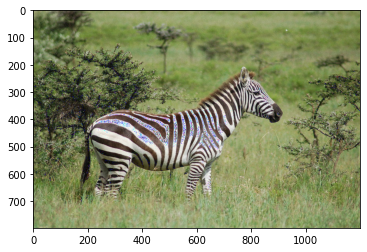

In [5]:
plt.imshow(add_guassian_noise(image, mean=0, sigma=5))

255


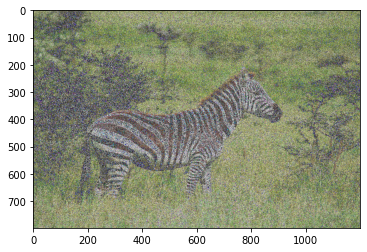

In [6]:
plt.imshow(add_guassian_noise(image, 5, 50))
print(add_guassian_noise(image, 150, 50).max()) # double checking we're not clipping over limit.

## 2. Remove Noise

In [7]:
def remove_noise(img: np.ndarray, filter: np.ndarray) -> np.ndarray:
    clean_image = np.zeros(img.shape, np.float32)
    if len(img.shape) == 2: # If this image is in grey scale
        clean_image = convolve2d(img, filter)
    else:
        clean_image[:, :, 0] = convolve2d(img[:, :, 0], filter, mode='same') # mode==padding = 'same'
        clean_image[:, :, 1] = convolve2d(img[:, :, 1], filter, mode='same')
        clean_image[:, :, 2] = convolve2d(img[:, :, 2], filter, mode='same')
    return clean_image.astype(np.uint8)# Change the dtype to uint (1byte, instead of 4for float or int)

In [23]:
# Trying three different filters.
## Gaussian Filter 3x3
filter_gaussian3 = np.array(([1, 2, 1],
                             [2, 4, 2],
                             [1, 2, 1]))
filter_gaussian3 = filter_gaussian3/16

## Gaussian Filter 5x5
filter_gaussian5 = np.array(([1, 4, 7, 4, 1],
                   [4, 16, 26, 16, 4],
                   [7, 26, 41, 26, 7],
                   [4, 16, 26, 16, 4],
                   [1, 0+4, 7, 4, 1]))
filter_gaussian5 = filter_gaussian5 / 273

## [forgot his name] Filter 3x3
filter = np.array(([5,3,6],[2,1,9],[8,4,7]))
filter = filter / 45

high_noise_zebra = add_guassian_noise(image, 500, 50)
noised_zebra = add_guassian_noise(image, 0, 25)
denoised_zebra = remove_noise(noised_zebra, filter_gaussian3)


### 2.1 subplots

(-0.5, 1199.5, 797.5, -0.5)

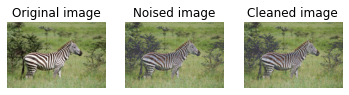

In [24]:
#Plotting using subplot:
plt.subplot(131)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.subplot(132)
plt.imshow(noised_zebra)
plt.title('Noised image')
plt.axis('off')
plt.subplot(133)
plt.imshow(denoised_zebra)
plt.title('Cleaned image')
plt.axis('off')

## 3. Diff between picutres

### 3.1 abs diff between 2 images:

In [9]:
delta_noised_v_denoised = (abs(denoised_zebra) - abs(noised_zebra))
abs_err = np.sum(delta_noised_v_denoised) 
print(f'absulute diff between noised & denoised image are: {abs_err}    [not normlized by num of pixels]')

absulute diff between noised & denoised image are: 359497963    [not normlized by num of pixels]


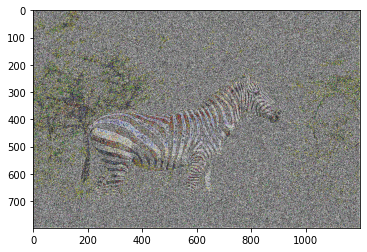

In [10]:
## See difference in a picutre:
plt.imshow(delta_noised_v_denoised)

#### 3.2 Comparing they're histograms

References:

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html


https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_image_histogram_calcHist.php

##### 3.2.1 Greyscale:

In [11]:
def show_greyscale_histogram(img_RGB: np.ndarray):
    gray_img = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2GRAY)
    # plt.imshow(gray_img,cmap='gray')
    hist = cv2.calcHist([gray_img],[0],None,[256],[0,256])
    hist,bins = np.histogram(gray_img,256,[0,256])

    plt.hist(gray_img.ravel(),256,[0,256])
    plt.title('Histogram for gray scale picture')
    plt.show()


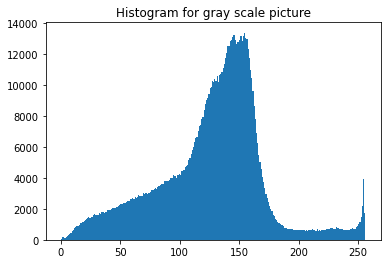

In [12]:
# Original Zebra
show_greyscale_histogram(image)

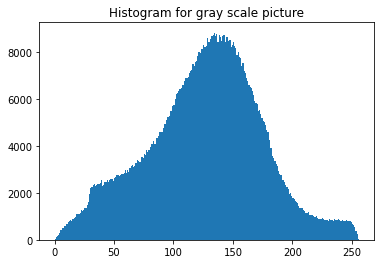

In [13]:
# Noised zebra
show_greyscale_histogram(noised_zebra)

clearly, we can see the gaussian bell, made the normal disterbution transformation

##### 3.2.2 Color (using CV, off the submission's record) 

In [14]:
def show_color_hist(img_RGB: np.ndarray):
    img = img_RGB.copy()
    color = ('r','g','b')
    for channel,col in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.title('This is my lovely zebra 🦓 histogram')
    plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129427 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129427 missing from current font.
  font.set_text(s, 0, flags=flags)


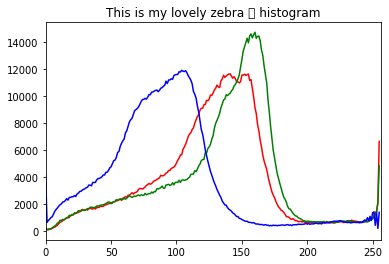

In [15]:
show_color_hist(image)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129427 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129427 missing from current font.
  font.set_text(s, 0, flags=flags)


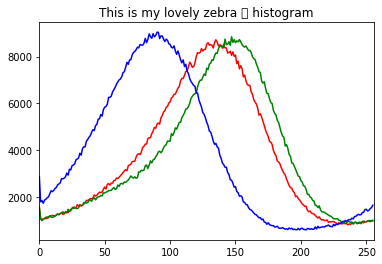

In [16]:
show_color_hist(noised_zebra)

### 3.3 Mean Squared Error Diff

In [17]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
    # 1. For each pixel in the image, get the diff between imA & imB and square it,
    # 2. sum the results for all the picture
    # 3. devide it by the num of pixels in the image
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) # 1+2
	err /= float(imageA.shape[0] * imageA.shape[1]) # 3
	# the lower the error, the more "similar"
	return err

print(f'Original_zebra & noised_zebra \'diff score\' are: {mse(image, noised_zebra)}')

print(f'Original_zebra & denoised_zebra \'diff score\' are: {mse(image, denoised_zebra)}') 

Original_zebra & noised_zebra 'diff score' are: 5297.564665831244
Original_zebra & denoised_zebra 'diff score' are: 1974.4788982873852


In [18]:
# Compare Filters: 

filter_res_dict = {} 
speed_dict = {}

from time import time

def filter_result(noised_image, filter, test_id_str, original_image=image):
    #1. start the timer
    start = time()
    #2. apply the noise removeoal
    denoised_res = remove_noise(noised_image, filter)
    #3. get the MSE scores from the origin 
    score_of_noised = mse(original_image,noised_image)
    score_of_denoised = mse(original_image,denoised_res)
    #4. add the speed and MSEs to the dictionaries 
    speed_dict[test_id_str] = np.round(time() - start, 3)
    filter_res_dict[test_id_str] = (score_of_noised/score_of_denoised).round(3) # higher is better
    #5. print the results
    print(f'score_of_noised: {score_of_noised.round(3)}\tscore_of_denoised:: {score_of_denoised:.3f}\nRun Time: {speed_dict[test_id_str]}')
    return filter_res_dict[test_id_str], speed_dict[test_id_str] 
    


filter_result(noised_zebra,filter,'forgot_name_filter' )
filter_result(noised_zebra,filter_gaussian3,'gaussian_3_filter' )
filter_result(noised_zebra,filter_gaussian5,'gaussian_5_filter' )

# Let's Sum-up"
print( '\n MSE ratio, Higher is better: ')
acc_dict_display = {k: v for k, v in sorted(filter_res_dict.items(), key = lambda i:i[1], reverse=True)}
display(acc_dict_display)

print('\n Speed:, Smaller is better ')
speed_dict_display= {k: v for k, v in sorted(speed_dict.items(), key = lambda i:i[1], reverse=True)}
display(speed_dict_display)


score_of_noised: 5297.565	score_of_denoised:: 2203.112
Run Time: 0.188
score_of_noised: 5297.565	score_of_denoised:: 1974.479
Run Time: 0.19
score_of_noised: 5297.565	score_of_denoised:: 1861.551
Run Time: 0.334

 MSE ratio, Higher is better: 


{'forgot_name_filter': 2.405,
 'gaussian_3_filter': 2.683,
 'gaussian_5_filter': 2.846}


 Speed:, Smaller is better 


{'forgot_name_filter': 0.188,
 'gaussian_3_filter': 0.19,
 'gaussian_5_filter': 0.334}

**Explain obtain scores:**

the MSE represents how different two pictures are, the lower the mse, the more they're alike. 
We can see that by adding the noise to the original_zebra we added a difference that scores 5287 in the MSE.
By using the filters we were able to decrease the total diff between the pictures to less then half.
The fact that we decreased the error means that we've actually improved the image's accuracy,
as the original_zebra stands for the ground-truth in this case.



## 4. Rotate image

In [19]:
from PIL import Image  

def rotate_image(img: np.ndarray, angle: float) -> np.ndarray:
    if angle % 360 == 0:
        return img.copy()
    return Image.fromarray(img).rotate(angle)

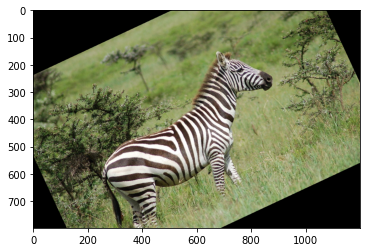

In [20]:
plt.imshow(rotate_image(image, 25))

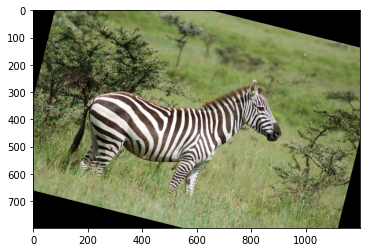

In [21]:
plt.imshow(rotate_image(image, 346))

In [25]:
%%shell
jupyter nbconvert --to html /content/Lab1_Prep_7march.ipynb

[NbConvertApp] Converting notebook /content/Lab1_Prep_7march.ipynb to html
[NbConvertApp] Writing 1906725 bytes to /content/Lab1_Prep_7march.html
